In [1]:
import jax.numpy as np
from jax import random, grad, jit, partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_fns import NODE_vmap as NN, init_params
import matplotlib.pyplot as plt
import pickle
from NODE_fns import NODE_lm2sigma_vmap
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Train NODE directly against stress

In another notebook I was looking into some of the analytical models and also the CANN model by Kevin and Ellen. The CANN model had an ok loss, not great, but was definitely polyconvex. The NODE was able to learn that model perfectly. 
Here I just want to train directly against the stress data. Not using the implementation from Vahid because it is not based on normalized quantities. Even when I was training the strain energy derivatives directly the results were not good without normalizing. The problem was to try to squeeze a 'I2' axis in the range [0,500] to a Psi2 range of [0.0008,0.0015] or so, in 100 steps of an explicit Euler. Normalizing the I2 axis and the output so that the input is in the range [0,3] and the output as well, then there was no issue with training. Following that approach here. 

In [2]:
## From Vahid's notebook, I do like the use of the 'model' class
# but adding normalization 
def P11_UT(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = lamb**2 + 2/lamb
    I2 = 2*lamb + 1/lamb**2
    I1norm = I1/I1_factor
    I2norm = I2/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2/lamb)*(lamb-1/lamb**2)
def P11_ET(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = 2*lamb**2 + 1/lamb**4
    I2 = lamb**4 + 2/lamb**2
    I1norm = I1/I1_factor
    I2norm = I2/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2*lamb**2)*(lamb-1/lamb**5)
def P11_PS(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 =  lamb**2 + 1/lamb**2 + 1
    I2 =  lamb**2 + 1/lamb**2 + 1
    I1norm = I1/I1_factor
    I2norm = I2/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1+Psi2)*(lamb-1/lamb**3)

In [3]:
def evalI1_UT(lam):
    return lam**2 + (2/lam)
def evalI2_UT(lam):
    return 2*lam + (1/lam**2)

def evalI1_ET(lam):
    return 2*lam**2 +1/lam**4
def evalI2_ET(lam):
    return lam**4 + 2/lam**2

def evalI1_PS(lam):
    return lam**2 + 1/lam**2 + 1
def evalI2_PS(lam):
    return lam**2 + 1/lam**2 + 1

In [4]:
# read the data
UTdata = pd.read_csv('UT20.csv')
ETdata = pd.read_csv('ET20.csv')
PSdata = pd.read_csv('PS20.csv')
# stack into single array 
P11_data = np.hstack([UTdata['P11'].to_numpy(),ETdata['P11'].to_numpy(),PSdata['P11'].to_numpy()])
F11_data = np.hstack([UTdata['F11'].to_numpy(),ETdata['F11'].to_numpy(),PSdata['F11'].to_numpy()])
# indices for the three data sets
indET = len(UTdata['P11'])
indPS = indET + len(ETdata['P11'])

In [5]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE():
    def __init__(self, params_I1, params_I2):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1norm(self, I1norm):
        return NN(I1norm-3.0, self.params_I1)
    def Psi2norm(self, I2norm):
        return NN(I2norm-3.0, self.params_I2)

In [6]:
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

@jit
def loss_P11_all(params, F11_data):
    lamUT = F11_data[0:indET]
    lamET = F11_data[indET:indPS]
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    model = NODE(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    P11ET_pr = P11_ET(lamET, model, normalization)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11UT_pr-P11_data[0:indET])**2)+np.mean((P11ET_pr-P11_data[indET:indPS])**2)+np.mean((P11PS_pr-P11_data[indPS:])**2)

@jit
def loss_P11_UT(params, F11_data):
    lamUT = F11_data[0:indET]
    params_I1 = params[0]
    params_I2 = params[1]
    model = NODE(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    return np.mean((P11UT_pr-P11_data[0:indET])**2)

@jit
def loss_P11_ET(params, F11_data):
    lamET = F11_data[indET:indPS]
    params_I1 = params[0]
    params_I2 = params[1]
    model = NODE(params_I1,params_I2)
    P11ET_pr = P11_ET(lamET, model, normalization)
    return np.mean((P11ET_pr-P11_data[indET:indPS])**2)

@jit
def loss_P11_PS(params, F11_data):
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    model = NODE(params_I1,params_I2)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11PS_pr-P11_data[indPS:])**2)



@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step(loss, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

layers = [2, 5, 5, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params)
#params, train_loss, val_loss = train(loss_P11, F11_data, opt_state, key, nIter = 50000) #Original 100000

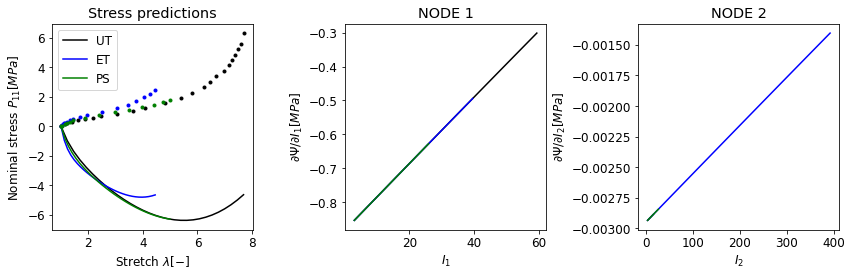

In [7]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE(params[0], params[1])
P11_NN_UT = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET = P11_ET(lamET_vec, model, normalization)
P11_NN_PS = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT, 'k',label='UT')

axs[0].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[0].plot(lamET_vec, P11_NN_ET, 'b',label='ET')

axs[0].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[0].plot(lamPS_vec, P11_NN_PS, 'g',label='PS')
axs[0].legend(loc=2)
axs[0].set_title('Stress predictions')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

I1_vec = evalI1_UT(lamUT_vec)
I2_vec = evalI2_UT(lamUT_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'k')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'k')

I1_vec = evalI1_ET(lamET_vec)
I2_vec = evalI2_ET(lamET_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'b')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'b')

I1_vec = evalI1_PS(lamPS_vec)
I2_vec = evalI2_PS(lamPS_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'g')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'g')

axs[1].set_title('NODE 1')
axs[2].set_title('NODE 2')
axs[1].set_xlabel(r'$I_1$')
axs[2].set_xlabel(r'$I_2$')
axs[1].set_ylabel(r'$\partial \Psi/\partial I_1 [MPa]$')
axs[2].set_ylabel(r'$\partial \Psi/\partial I_2 [MPa]$')


plt.tight_layout()
#plt.savefig('NODE.png',dpi=200)

In [8]:
## Let's finish with the error
lamUT = F11_data[0:indET]
lamET = F11_data[indET:indPS]
lamPS = F11_data[indPS:]
errorNODE_UT = np.mean(np.abs(P11_UT(lamUT, model, normalization)-UTdata['P11'].to_numpy()))
errorNODE_ET = np.mean(np.abs(P11_ET(lamET, model, normalization)-ETdata['P11'].to_numpy()))
errorNODE_PS = np.mean(np.abs(P11_PS(lamPS, model, normalization)-PSdata['P11'].to_numpy()))
errorNODE = 1/3*(errorNODE_UT+errorNODE_ET+errorNODE_PS)
print('MAE NODE')
print(errorNODE)

MAE NODE
4.694799569887891


## Training with one set of data and comparing to the others 

In [9]:
# train with uniaxial only
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss_P11_UT, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 2.115974e+01
it 2000, train loss = 5.202055e+00
it 3000, train loss = 1.213024e+00
it 4000, train loss = 2.737887e-01
it 5000, train loss = 2.025354e-01
it 6000, train loss = 1.934377e-01
it 7000, train loss = 1.856819e-01
it 8000, train loss = 1.767102e-01
it 9000, train loss = 1.644837e-01
it 10000, train loss = 1.492104e-01
it 11000, train loss = 1.329793e-01
it 12000, train loss = 1.185501e-01
it 13000, train loss = 1.079431e-01
it 14000, train loss = 1.007786e-01
it 15000, train loss = 9.577219e-02
it 16000, train loss = 9.230520e-02
it 17000, train loss = 8.909602e-02
it 18000, train loss = 8.303182e-02
it 19000, train loss = 6.407530e-02
it 20000, train loss = 3.926074e-02
it 21000, train loss = 2.506226e-02
it 22000, train loss = 1.505462e-02
it 23000, train loss = 7.835891e-03
it 24000, train loss = 4.692058e-03
it 25000, train loss = 4.111048e-03
it 26000, train loss = 4.033236e-03
it 27000, train loss = 3.993621e-03
it 28000, train loss = 3.956499e-03
i

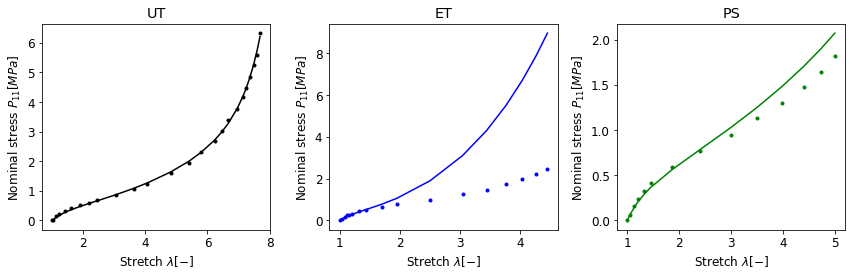

In [10]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

# lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
# lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
# lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE(params[0], params[1])
P11_NN_UT_u = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_u = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_u = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_u, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_u, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_u, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

# I1_vec = evalI1_UT(lamUT_vec)
# I2_vec = evalI2_UT(lamUT_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'k')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'k')

# I1_vec = evalI1_ET(lamET_vec)
# I2_vec = evalI2_ET(lamET_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'b')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'b')

# I1_vec = evalI1_PS(lamPS_vec)
# I2_vec = evalI2_PS(lamPS_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'g')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'g')

# axs[1].set_title('NODE 1')
# axs[2].set_title('NODE 2')
# axs[1].set_xlabel(r'$I_1$')
# axs[2].set_xlabel(r'$I_2$')
# axs[1].set_ylabel(r'$\partial \Psi/\partial I_1 [MPa]$')
# axs[2].set_ylabel(r'$\partial \Psi/\partial I_2 [MPa]$')
plt.tight_layout()
plt.savefig('NODE_UT_ri.png',dpi=200)

In [11]:
panels = ['A', 'E', 'I']
P_pr = [P11_NN_UT_u, P11_NN_ET_u, P11_NN_PS_u]
P_gt = [UTdata['P11'], ETdata['P11'], PSdata['P11']]
lamb = [lamUT_vec, lamET_vec, lamPS_vec]
for panel, lm, P11_gt, P11_pr in zip(panels, lamb, P_gt, P_pr):
    data = np.array([lm, P11_gt, P11_pr])
    data = np.clip(data, a_min=-100,a_max=100)
    header = ['x', 'y_gt', 'y_node']
    df = pd.DataFrame(data.T, columns=header)
    df.to_csv('TikZ/fig_rubber_data/fig_rubber_' + panel + '.csv', index=False, sep=' ')

In [12]:
# train with equibiaxial only, 
# note I'm starting already from the previously trained network on UT
# ok let's reset and do from scratch because maybe this is too good
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss_P11_ET, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 7.606730e+00
it 2000, train loss = 1.913751e+00
it 3000, train loss = 3.959788e-01
it 4000, train loss = 6.473837e-02
it 5000, train loss = 2.281273e-02
it 6000, train loss = 1.361828e-02
it 7000, train loss = 8.580983e-03
it 8000, train loss = 6.267786e-03
it 9000, train loss = 5.167479e-03
it 10000, train loss = 4.530909e-03
it 11000, train loss = 3.726638e-03
it 12000, train loss = 6.959750e-04
it 13000, train loss = 3.370433e-04
it 14000, train loss = 2.077369e-04
it 15000, train loss = 1.520692e-04
it 16000, train loss = 1.243482e-04
it 17000, train loss = 1.074098e-04
it 18000, train loss = 9.878201e-05
it 19000, train loss = 9.442267e-05
it 20000, train loss = 9.149016e-05
it 21000, train loss = 8.887514e-05
it 22000, train loss = 8.676002e-05
it 23000, train loss = 8.554040e-05
it 24000, train loss = 8.481020e-05
it 25000, train loss = 8.428594e-05
it 26000, train loss = 8.387721e-05
it 27000, train loss = 8.353332e-05
it 28000, train loss = 8.323273e-05
i

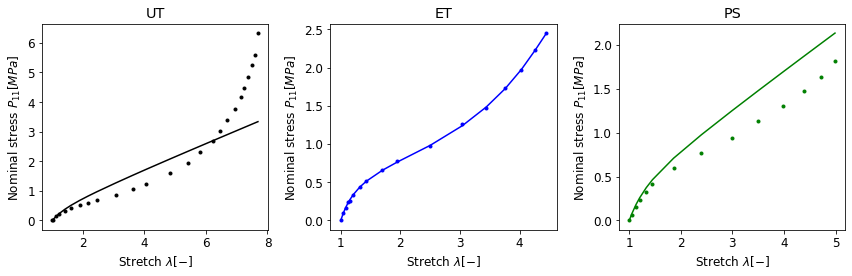

In [13]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

# lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
# lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
# lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE(params[0], params[1])
P11_NN_UT_e = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_e = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_e = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_e, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_e, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_e, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()
plt.savefig('NODE_ET_ri.png',dpi=200)

In [14]:
panels = ['B', 'F', 'J']
P_pr = [P11_NN_UT_e, P11_NN_ET_e, P11_NN_PS_e]
P_gt = [UTdata['P11'], ETdata['P11'], PSdata['P11']]
lamb = [lamUT_vec, lamET_vec, lamPS_vec]
for panel, lm, P11_gt, P11_pr in zip(panels, lamb, P_gt, P_pr):
    data = np.array([lm, P11_gt, P11_pr])
    data = np.clip(data, a_min=-100,a_max=100)
    header = ['x', 'y_gt', 'y_node']
    df = pd.DataFrame(data.T, columns=header)
    df.to_csv('TikZ/fig_rubber_data/fig_rubber_' + panel + '.csv', index=False, sep=' ')

In [15]:
# train with pure shear only, 
# note I'm starting already from the previously trained network on ET
# ok, starting from random values to be fair
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss_P11_PS, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 9.714635e+00
it 2000, train loss = 2.308433e+00
it 3000, train loss = 4.507282e-01
it 4000, train loss = 7.440855e-02
it 5000, train loss = 2.213852e-02
it 6000, train loss = 1.473872e-02
it 7000, train loss = 9.135002e-03
it 8000, train loss = 5.368386e-03
it 9000, train loss = 3.412355e-03
it 10000, train loss = 2.505664e-03
it 11000, train loss = 2.100701e-03
it 12000, train loss = 1.923883e-03
it 13000, train loss = 1.849357e-03
it 14000, train loss = 1.818727e-03
it 15000, train loss = 1.803800e-03
it 16000, train loss = 1.790285e-03
it 17000, train loss = 1.770681e-03
it 18000, train loss = 1.740616e-03
it 19000, train loss = 1.697058e-03
it 20000, train loss = 1.639563e-03
it 21000, train loss = 1.574036e-03
it 22000, train loss = 1.511628e-03
it 23000, train loss = 1.455870e-03
it 24000, train loss = 1.400302e-03
it 25000, train loss = 1.342532e-03
it 26000, train loss = 1.289606e-03
it 27000, train loss = 1.249261e-03
it 28000, train loss = 1.218831e-03
i

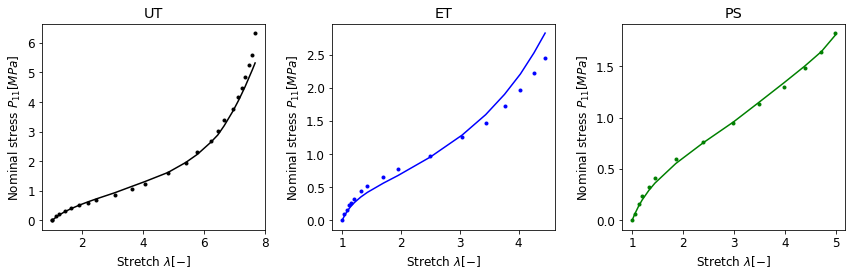

In [16]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

# lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
# lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
# lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE(params[0], params[1])
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()
plt.savefig('NODE_PS_ri.png',dpi=200)

In [17]:
panels = ['C', 'G', 'K']
P_pr = [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p]
P_gt = [UTdata['P11'], ETdata['P11'], PSdata['P11']]
lamb = [lamUT_vec, lamET_vec, lamPS_vec]
for panel, lm, P11_gt, P11_pr in zip(panels, lamb, P_gt, P_pr):
    data = np.array([lm, P11_gt, P11_pr])
    data = np.clip(data, a_min=-100,a_max=100)
    header = ['x', 'y_gt', 'y_node']
    df = pd.DataFrame(data.T, columns=header)
    df.to_csv('TikZ/fig_rubber_data/fig_rubber_' + panel + '.csv', index=False, sep=' ')

In [18]:
# train with everything
# note I'm starting already from the previously trained network on ET
# ok, starting from random values to be fair
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss_P11_all, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 3.877332e+01
it 2000, train loss = 9.566222e+00
it 3000, train loss = 2.134644e+00
it 4000, train loss = 4.892382e-01
it 5000, train loss = 3.452898e-01
it 6000, train loss = 3.352215e-01
it 7000, train loss = 3.232392e-01
it 8000, train loss = 3.063843e-01
it 9000, train loss = 2.842687e-01
it 10000, train loss = 2.583741e-01
it 11000, train loss = 2.311603e-01
it 12000, train loss = 2.056911e-01
it 13000, train loss = 1.862767e-01
it 14000, train loss = 1.742371e-01
it 15000, train loss = 1.663904e-01
it 16000, train loss = 1.598362e-01
it 17000, train loss = 1.496131e-01
it 18000, train loss = 1.303596e-01
it 19000, train loss = 1.088103e-01
it 20000, train loss = 7.756657e-02
it 21000, train loss = 2.727313e-02
it 22000, train loss = 1.276632e-02
it 23000, train loss = 1.234027e-02
it 24000, train loss = 1.218318e-02
it 25000, train loss = 1.207553e-02
it 26000, train loss = 1.196436e-02
it 27000, train loss = 1.187458e-02
it 28000, train loss = 1.179523e-02
i

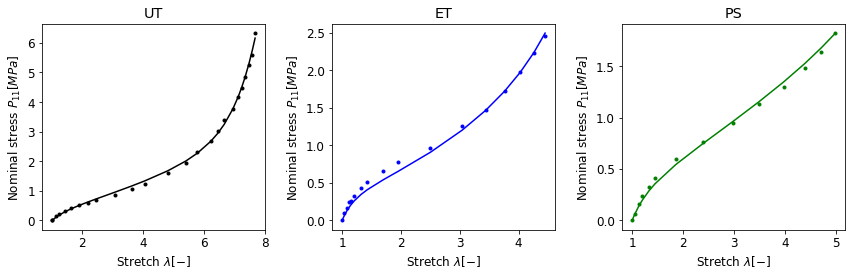

In [19]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

# lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
# lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
# lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE(params[0], params[1])
P11_NN_UT_a = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_a = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_a = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_a, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_a, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_a, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()
plt.savefig('NODE_ET_ri.png',dpi=200)

In [20]:
panels = ['D', 'H', 'L']
P_pr = [P11_NN_UT_a, P11_NN_ET_a, P11_NN_PS_a]
P_gt = [UTdata['P11'], ETdata['P11'], PSdata['P11']]
lamb = [lamUT_vec, lamET_vec, lamPS_vec]
for panel, lm, P11_gt, P11_pr in zip(panels, lamb, P_gt, P_pr):
    data = np.array([lm, P11_gt, P11_pr])
    data = np.clip(data, a_min=-100,a_max=100)
    header = ['x', 'y_gt', 'y_node']
    df = pd.DataFrame(data.T, columns=header)
    df.to_csv('TikZ/fig_rubber_data/fig_rubber_' + panel + '.csv', index=False, sep=' ')

In [35]:
panels = ['A','B','C','D','E','F','G','H','I','J','K','L']
# panels = ['A']
for panel in panels:
    df = pd.read_csv('TikZ/fig_rubber_data/CANN_' + panel + '.csv', names=['x','y'])
    df['y'] = df['y']/10
    df.to_csv('TikZ/fig_rubber_data/CANN_' + panel + '.csv', index=False, sep=' ')